In [28]:
N = 100000		# Tamanho da população
FREQ_A = 0.75	# Frequência inicial do alelo A
GENS = 100		# Número de gerações a simular
T1 = GENS/2		# Geração na qual é introduzida a nova pressão seletiva
W = {			# Fitness para cada genótipo em função da geração
	"AA": lambda g: 1.00 if g < T1 else 0.861, 
	"Aa": lambda g: 1.00 if g < T1 else 0.935,
	"aa": lambda g: 0.95 if g < T1 else 1.00
}

In [29]:
def theoretical_allele_freq(freq_A: float, gen: int) -> float:
	"""Calcula a frequência teórica do alelo A na geração gen, a partir da frequência inicial freq_A"""
	g = gen
	
	f_A = freq_A
	f_a = 1-f_A
	f_AA = f_A**2
	f_Aa = 2*f_A*f_a
	f_aa = f_a**2

	w = f_AA*W["AA"](g) + f_Aa*W["Aa"](g) + f_aa*W["aa"](g)
	return ((f_AA)*W["AA"](g) + (f_A*f_a)*W["Aa"](g)) / w


def theoretical_genotype_freqs(freq_A: float, gen: int) -> dict:
	"""Calcula a frequência teórica de cada genótipo na geração gen, a partir da frequência inicial freq_A"""
	g = gen
	
	f_A = freq_A
	f_a = 1-f_A
	f_AA = f_A**2
	f_Aa = 2*f_A*f_a
	f_aa = f_a**2

	w = f_AA*W["AA"](g) + f_Aa*W["Aa"](g) + f_aa*W["aa"](g)
	return {
		"AA": (f_AA*W["AA"](g)) / w,
		"Aa": (f_Aa*W["Aa"](g)) / w,
		"aa": (f_aa*W["aa"](g)) / w
	}


# Calculate with the theoretical model
allele_history_theoretical = [FREQ_A]
for g in range(GENS):
	freq_A = allele_history_theoretical[-1]
	allele_history_theoretical.append(theoretical_allele_freq(freq_A, g))

genotype_history_theoretical = {
	"AA": [int(N*FREQ_A**2)],
	"Aa": [int(N*2*FREQ_A*(1-FREQ_A))],
	"aa": [int(N*(1-FREQ_A)**2)]
}
for g in range(GENS):
	freq_A = allele_history_theoretical[g]
	genotype_freqs = theoretical_genotype_freqs(freq_A, g)
	for genotype in genotype_freqs:
		genotype_history_theoretical[genotype].append(genotype_freqs[genotype]*N)


In [30]:
from random import choice, choices

def get_genotype_frequencies(population: dict) -> dict:
	"""Dada uma população, retorna a frequência de cada genótipo"""
	# N = sum(population.values())
	freqs = {}
	for genotype in population:
		freqs[genotype] = population[genotype] / N

	return freqs


def simulate_sex(ind1: str, ind2: str) -> str:
	"""Dados os genótipos de dois indivíduos diploides, retorna o de sua prole"""
	return "".join(sorted(choice(ind1) + choice(ind2)))


def simulate_generation(population: dict, fitness: dict):
	"""Dada uma população e o fitness de cada genótipo, retorna a população da próxima geração"""
	# N = sum(population.values())

	# Frequência de cada genótipo e do alelo A
	g_freqs = get_genotype_frequencies(population)
	freq_A = (g_freqs["AA"] + g_freqs["Aa"]/2)

	# A probabilidade de reprodução de cada genótipo é seu valor adaptativo vezes sua frequência na população
	p = {genotype: fitness[genotype] * g_freqs[genotype] for genotype in population}

	new_population = {genotype: 0 for genotype in population}
	for n in range(N):
		# Escolhe um par de indivíduos para se reproduzir
		# Observação: é possivel que um indivíduo se reproduza com ele mesmo
		genotypes = list(p.keys())
		reprod_prob = list(p.values())
		pair = choices(genotypes, k=2, weights=reprod_prob)
		# Adiciona a prole à nova população
		new_population[simulate_sex(pair[0], pair[1])] += 1
	
	return new_population, freq_A, g_freqs


def simulate(freq_A: float, N: int, gens: int):
	"""Simula a evolução de uma população com frequência inicial do alelo A = freq_A por gens gerações"""
	# Montamos uma população inicial com frequência de A = freq_A
	F_AA, F_Aa, F_aa = freq_A**2, 2*freq_A*(1-freq_A), (1-freq_A)**2
	N_AA, N_Aa, N_aa = int(N*F_AA), int(N*F_Aa), int(N*F_aa)
	population = {"AA": N_AA, "Aa": N_Aa, "aa": N_aa}
	genotype_history = {"AA": [N_AA], "Aa": [N_Aa], "aa": [N_aa]}

	allele_history = [freq_A]

	# Itera sobre as gerações
	for g in range(gens):
		# Resolve o fitness de cada genótipo na geração a ser simulada
		fitness = {genotype: W[genotype](g) for genotype in population}

		population, freq_A, genotype_freqs = simulate_generation(population, fitness)

		# print(f"{g+1}: \t{population}")
		
		allele_history.append(freq_A)
		for genotype in population:
			genotype_history[genotype].append(population[genotype])

	return genotype_history, allele_history#, genotype_history


genotype_history, allele_history = simulate(
	freq_A=FREQ_A,
	N=N,
	gens=GENS
)

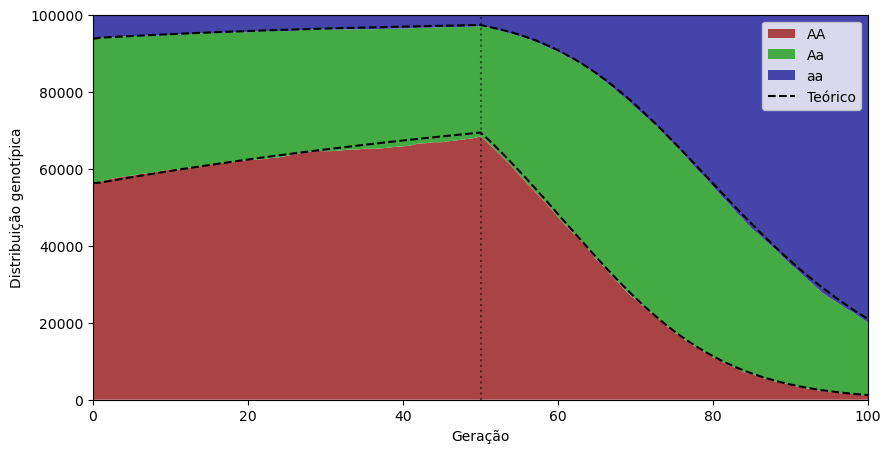

In [41]:
import matplotlib.pyplot as plt

plt.subplots(figsize=(10, 5))

# Plot genotype representation
plt.stackplot(range(GENS+1),
			genotype_history["AA"],
			genotype_history["Aa"],
			genotype_history["aa"],
			labels=["AA", "Aa", "aa"],
			colors=["#A44", "#4A4", "#44A"]
)

# Do some shenannigans to make it line up with the stackplot
line_color = "black"
plt.plot(
	[N-N_aa for N_aa in genotype_history_theoretical["aa"]],
	color=line_color, linestyle="dashed"
)
plt.plot(genotype_history_theoretical["AA"],
    color=line_color,
    linestyle="dashed",
    label="Teórico"
)



plt.xlabel('Geração')
plt.xlim(0, GENS)
plt.ylabel('Distribuição genotípica')
plt.ylim(0, N)

# Environmental change line
plt.plot([T1, T1], [0, N], color="white", linestyle="dotted", alpha=0.5)



plt.legend(loc='best')
plt.savefig("genotype_distribution.png", dpi=300, transparent=True)

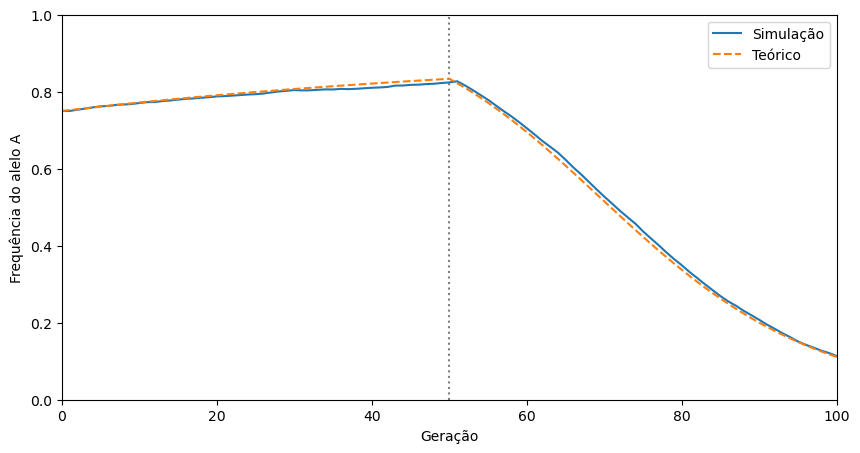

In [40]:
import matplotlib.pyplot as plt

plt.subplots(figsize=(10, 5))

# Environmental change indicator line
plt.plot([T1, T1], [0, 1], color="black", linestyle="dotted", alpha=0.5)

# Plot allele frequencies
plt.plot(allele_history, label="Simulação")
plt.plot(allele_history_theoretical, label="Teórico", linestyle="dashed")
plt.xlabel('Geração')
plt.ylabel('Frequência do alelo A')
plt.ylim(0, 1)
plt.xlim(0, GENS)

plt.legend(loc='best')
plt.savefig("allele_freq.png", dpi=300, transparent=True)